In [1]:
import hpfrec

#### We train the model on 80% data. Remaining 20% we use for testing.

In [25]:
"""Fitting the model on training data, instead of validation set."""
recommender = hpfrec.HPF(k=30, reindex=False, stop_crit='train-llk', verbose=True, stop_thr=0.000001, maxiter=3000, random_seed=123,
                        save_folder='~/Documents/RedHat/f8a-pypi-insights/notebooks')

In [3]:
import pickle

In [4]:
with open('training-data-without-trans.pkl', 'rb') as f:
    train_df = pickle.load(f)

In [5]:
with open('test-data-without-trans.pkl', 'rb') as f:
    test_df = pickle.load(f)

#### We fit the model on training data

In [26]:
recommender.fit(train_df)

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 66018
Number of items: 18796
Latent factors to use: 30

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -2038810 | train rmse: 0.9515
Iteration 20 | train llk: -1944271 | train rmse: 0.9387
Iteration 30 | train llk: -1919819 | train rmse: 0.9353
Iteration 40 | train llk: -1909631 | train rmse: 0.9337
Iteration 50 | train llk: -1905902 | train rmse: 0.9331
Iteration 60 | train llk: -1903816 | train rmse: 0.9328
Iteration 70 | train llk: -1902694 | train rmse: 0.9326
Iteration 80 | train llk: -1901842 | train rmse: 0.9323
Iteration 90 | train llk: -1901214 | train rmse: 0.9321
Iteration 100 | train llk: -1900767 | train rmse: 0.9320
Iteration 110 | train llk: -1900406 | train rmse: 0.9319
Iteration 120 | train llk: -1900149 | train rmse: 0.9318
Iteration 130 | train llk: -1899945 | train rmse: 0.931

In [7]:
import pandas as pd
import numpy as np

#### Calculate recall for the trained model on test data

In [8]:
def recall_at_m(m):
    recall = []
    for i in range(66018):
        x = np.array(test_df.loc[test_df.UserId.isin([i])].ItemId)
        l = len(x)
        recommendations = recommender.topN(user=i, n=m, exclude_seen=True)
        intersection_length = len(np.intersect1d(x, recommendations))
        try:
            recall.append({"recall": intersection_length/l, "length": l, "user": i})
        except ZeroDivisionError as e:
            pass
    
    recall_df = pd.DataFrame(recall, index=None)
    return recall_df['recall'].mean()

In [27]:
recall_at_m(50)

0.4187862138325263

In [10]:
recall_at_m(100)

0.531125868568053

In [11]:
recall_at_m(200)

0.6367153485518058

In [12]:
recall_at_m(300)

0.6951519550672638

In [13]:
import pickle

In [14]:
"""Save the model"""
recommender.step_size = None
with open('HPF_model_without_trans.pkl', 'wb') as f:
    pickle.dump(recommender, f)

In [15]:
with open('HPF_model_without_trans.pkl', 'rb') as f:
    recommender = pickle.load(f)

#### We will do some common sense checks here to see if we trained the model correctly. To do that, predictions should:

1. Be higher for this non-zero hold-out sample than for random items.
2. Produce a good discrimination between random items and those in the hold-out sample (very related to the first point).
3. Be correlated with the playcounts in the hold-out sample.
4. Follow an exponential distribution rather than a normal or some other symmetric distribution.

In [16]:
import numpy as np

In [28]:
test_df['Predicted'] = recommender.predict(user=test_df.UserId, item=test_df.ItemId)
test_df['RandomItem'] = np.random.choice(train_df.ItemId, size=test_df.shape[0])
test_df['PredictedRandom'] = recommender.predict(user=test_df.UserId, item=test_df.RandomItem)
print("Average prediction for combinations in test set: ", test_df.Predicted.mean())
print("Average prediction for random combinations: ", test_df.PredictedRandom.mean())

Average prediction for combinations in test set:  0.043578032
Average prediction for random combinations:  0.02935503


In [18]:
from sklearn.metrics import roc_auc_score

was_played = np.r_[np.ones(test_df.shape[0]), np.zeros(test_df.shape[0])]
score_model = np.r_[test_df.Predicted.values, test_df.PredictedRandom.values]
roc_auc_score(was_played, score_model)

0.594698111233428

In [19]:
# This is nan, because predict is bound to provide NaN values
np.corrcoef(test_df.Count, test_df.Predicted)[0,1]

/Users/aagamshah/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/aagamshah/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan

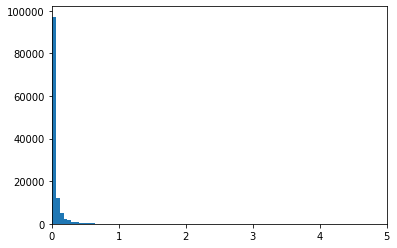

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.hist(test_df.Predicted, bins=80)
plt.xlim(0,5)
plt.show()